# Supercompressible: regression 3d (critical buckling load)

This notebook intends to show the application of Gaussian processes to make predictions about the critical buckling load in the supercompressible example.

So, let's start by importing the required libraries:

In [1]:
# standard library
import pickle

# third-party
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.gaussian_process.kernels import Matern

Now, let's import the data.

In [2]:
# get pandas frame
filename = 'DoE_results.pkl'
with open(filename, 'rb') as file:
    data = pickle.load(file)
points = data['points']
print('variables:', [col for col in points.columns])

# get number of inputs
n_inputs = len(points.columns) - 3

# get X data
X = points.iloc[:,range(n_inputs)].values

# get y data
var_name = 'sigma_crit'
y = points.loc[:, var_name].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

variables: ['ratio_d', 'ratio_pitch', 'ratio_top_diameter', 'coilable', 'sigma_crit', 'energy']
X: [[0.004      0.25       0.        ]
 [0.0385     0.875      0.4       ]
 [0.05575    0.5625     0.2       ]
 ...
 [0.06037836 1.08930969 0.58618164]
 [0.04312836 0.77680969 0.38618164]
 [0.00862836 1.40180969 0.78618164]]
X shape: (10000, 3)
y: [4.94204110e-04            nan 2.30520020e+01 ... 5.15127255e+01
 1.05456065e+01 1.21153836e-02]
y shape: (10000,)


The variables ```X``` and ```y``` contain all the data. Nevertheless, there's ```NaN``` values that cannot be considered.

In [3]:
# missing indices
indices = pd.notnull(points.loc[:, var_name]).values

# get y data
y = points.loc[indices, var_name].values

# get X data
X = points.iloc[indices,range(n_inputs)].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

X: [[0.004      0.25       0.        ]
 [0.05575    0.5625     0.2       ]
 [0.02125    1.1875     0.6       ]
 ...
 [0.06037836 1.08930969 0.58618164]
 [0.04312836 0.77680969 0.38618164]
 [0.00862836 1.40180969 0.78618164]]
X shape: (9503, 3)
y: [4.94204110e-04 2.30520020e+01 6.93775496e-01 ... 5.15127255e+01
 1.05456065e+01 1.21153836e-02]
y shape: (9503,)


In [4]:
# missing indices
indices = pd.notnull(points.loc[:, var_name]).values

# get y data
y = points.loc[indices, var_name].values

# get X data
X = points.iloc[indices,range(n_inputs)].values

print('X:', X)
print('X shape:', np.shape(X))
print('y:', y)
print('y shape:', np.shape(y))

X: [[0.004      0.25       0.        ]
 [0.05575    0.5625     0.2       ]
 [0.02125    1.1875     0.6       ]
 ...
 [0.06037836 1.08930969 0.58618164]
 [0.04312836 0.77680969 0.38618164]
 [0.00862836 1.40180969 0.78618164]]
X shape: (9503, 3)
y: [4.94204110e-04 2.30520020e+01 6.93775496e-01 ... 5.15127255e+01
 1.05456065e+01 1.21153836e-02]
y shape: (9503,)


Text(0, 0.5, 'Frequency')

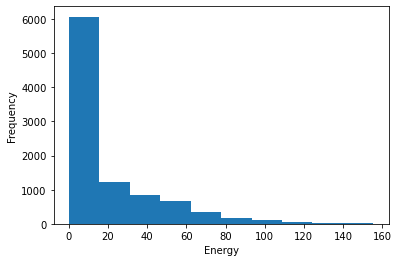

In [5]:
fig1, ax1 = plt.subplots()
ax1.hist(y);
ax1.set_xlabel('Energy')
ax1.set_ylabel('Frequency')

In [6]:
def perform_cleaning(X, y, n_std_cleaning):
    
    # compute threshold
    y_mean, y_std = np.mean(y), np.std(y)
    y_thresh = y_mean + n_std_cleaning * y_std

    # indices
    print(y_thresh)
    indices = np.where(y < y_thresh)
    print('Dismissed points:', len(y) - len(indices[0]))

    # X and y
    y = y[indices]
    X = X[indices]
    print(np.shape(y))
    print(np.shape(X))

    return X, y

In [7]:
n_std_cleaning = 5  # dismiss points that fall outside this range

X, y = perform_cleaning(X, y, n_std_cleaning)

144.159784301271
Dismissed points: 6
(9497,)
(9497, 3)


Text(0, 0.5, 'Frequency')

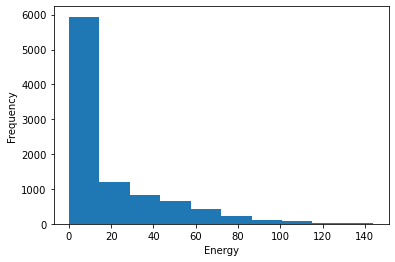

In [8]:
fig1, ax1 = plt.subplots()
ax1.hist(y);
ax1.set_xlabel('Energy')
ax1.set_ylabel('Frequency')

Before starting to make predictions, let's create a function that to train a Gaussian process regressor given the kernel. The function will print the error metrics and plot the predicted values against the observed values.

In [9]:
def make_gp_regression(X_train, y_train, kernel):
    
    # train model
    model = GaussianProcessRegressor(kernel=kernel, alpha=0.1**2, 
                                   n_restarts_optimizer=0)
    model.fit(X_train, y_train)
    
    return model

In [10]:
def split_data(X, y, train_size):
    
    # split data
    test_size = 1 - train_size
    indices = range(len(y))
    X_train = X[indices[:-int(round(len(indices) * test_size))]]
    X_test = X[indices[-int(round(len(indices) * test_size)):]]
    y_train = y[indices[:-int(round(len(indices) * test_size))]]
    y_test = y[indices[-int(round(len(indices) * test_size)):]]
    
    return (X_train, X_test, y_train, y_test)

In [11]:
def evaluate_model(model, X_test, y_mean_test, n_train):
    
    # predict test
    y_mean_pred = model.predict(X_test, return_std=False)

    # error metrics
    mse = mean_squared_error(y_mean_test, y_mean_pred)
    r2 = r2_score(y_mean_test, y_mean_pred)
    expl_var = explained_variance_score(y_mean_test, y_mean_pred)
    print("The mean squared error is %0.3e" % mse)
    print("The R2 score is %0.3f" % r2)
    print("The explained variance score is %0.3f" % expl_var)

    # plot predicted vs observed
    plt.figure()
    plt.plot(y_mean_test, y_mean_pred, 'o')
    plt.plot([np.min(y_mean_test), np.max(y_mean_test)], [np.min(y_mean_test), np.max(y_mean_test)], 'r-')
    plt.title('Posterior kernel: %s\n$n_{train} = %i$, $R^{2} = %0.3f$, $ MSE = %0.3e$' % (model.kernel_, n_train, r2, mse))
    plt.ylabel("Predicted")
    plt.xlabel("Observed")
    plt.show()

So, let's split the data and start to make some predictions!

The mean squared error is 4.099e+00
The R2 score is 0.993
The explained variance score is 0.993


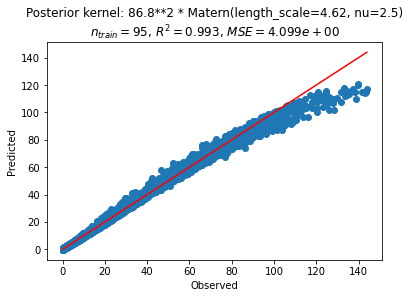

In [12]:
# choose train size
train_size = .01
(X_train, X_test, y_train, y_test) = split_data(X, y, train_size)
n_train = len(X_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train and predict
kernel = 1.0 * Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(1e-1, 10.0))
model = make_gp_regression(X_train_scaled, y_train, kernel)

# evaluate model
evaluate_model(model, X_test_scaled, y_test, n_train)

Contrary to the energy. Here it does not make any sense to speak about cleaning the data. We can also see that with 95 datapoints we already have reasonable predictions. Let's see how the data set size influences the results.

The mean squared error is 4.099e+00
The R2 score is 0.993
The explained variance score is 0.993


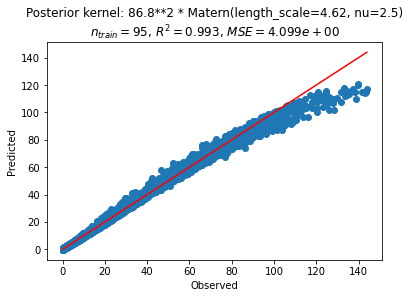

The mean squared error is 1.209e+00
The R2 score is 0.998
The explained variance score is 0.998


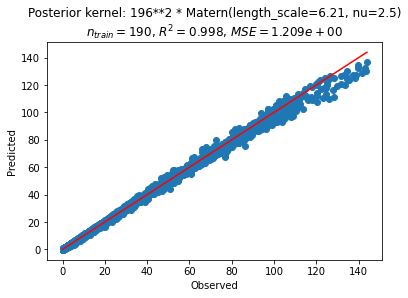

The mean squared error is 4.300e-01
The R2 score is 0.999
The explained variance score is 0.999


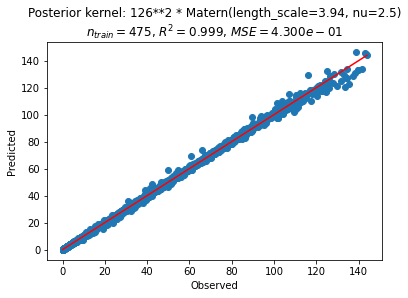

The mean squared error is 1.512e-01
The R2 score is 1.000
The explained variance score is 1.000


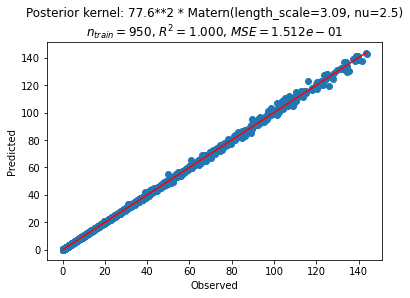

The mean squared error is 2.994e-02
The R2 score is 1.000
The explained variance score is 1.000


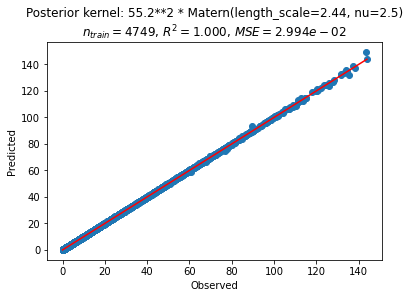

In [13]:
# choose train size
train_size = [.01, 0.02, 0.05, 0.1, 0.5]

# train and predict
scalers = []
models = []
for train_size_ in train_size:
    # choose train size
    (X_train, X_test, y_train, y_test) = split_data(X, y, train_size_)
    n_train = len(X_train)

    # scale data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # train and predict
    kernel = 1.0 * Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(1e-1, 10.0))
    model = make_gp_regression(X_train_scaled, y_train, kernel)

    # evaluate model
    evaluate_model(model, X_test_scaled, y_test, n_train)
    
    # store models
    scalers.append(scaler)
    models.append(model)

Let's define function to plot the outputs.

In [14]:
def make_reg_plot(scaler, reg, variables, x3, labels, bounds):

    column_names = [col for col in points.columns]

    indices =  [column_names.index(name) for name in variables]

    xx = np.meshgrid(np.arange(bounds[0][0], bounds[0][1], 0.02),
                          np.arange(bounds[1][0], bounds[1][1], 0.02))

    n = len(xx[0].ravel())
    xx.append(x3 * np.ones(n))

    XX = np.empty((n, 3))
    for index, xx_ in zip(indices, xx):
        XX[:, index] = xx_.ravel()

    XX_scaled = scaler.transform(XX)

    Y = reg.predict(XX_scaled)
    Y = Y.reshape(xx[0].shape)

    # plot
    fig, ax = plt.subplots()
    cs = ax.contourf(xx[0], xx[1], Y, alpha=0.8, cmap=plt.get_cmap('jet'))
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_title('%s = %.2g' % (labels[2], x3))
    fig.colorbar(cs)

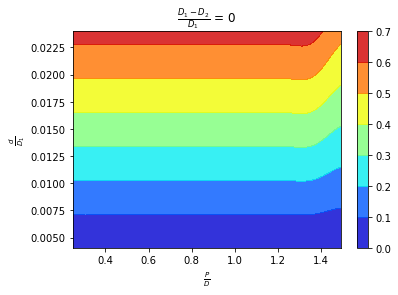

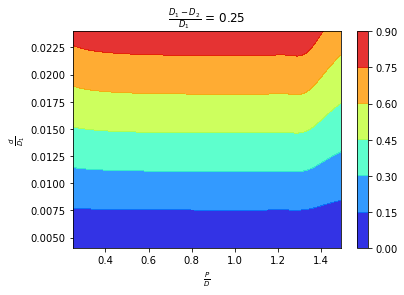

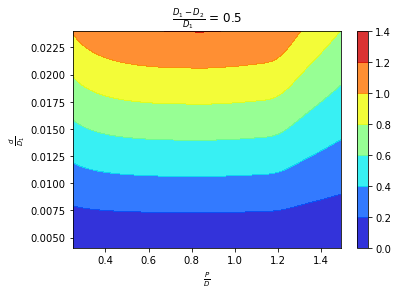

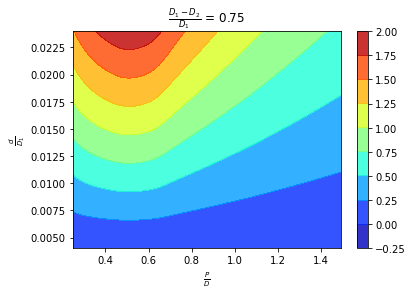

In [15]:
variables = ['ratio_pitch', 'ratio_d', 'ratio_top_diameter']
labels = ['$\\frac{P}{D}$', '$\\frac{d}{D_1}$', '$\\frac{D_1 - D_2}{D_1}$']
bounds = [data['doe_variables'][name] for name in variables]
bounds[1] = [0.004, 0.025]

scaler = scalers[-1]
reg = models[-1]

for x3 in [0., 0.25, 0.5, 0.75]:
    make_reg_plot(scaler, reg, variables, x3, labels, bounds)